# 数据集探索 Dataset Explorations

In [1]:
import os
import sys
import cv2
import h5py
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from tqdm import tqdm
from utils import get_params_count

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.applications import inception_v3, xception, resnet50, vgg16, vgg19
from keras.applications import InceptionV3, Xception, ResNet50, VGG16, VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.optimizers import SGD

Using TensorFlow backend.


## 读入数据

In [4]:
train_name = os.listdir('./train')
test_name = os.listdir('./test')
train_size = len(train_name)
test_size = len(test_name)

Y_train = pd.read_csv('labels.csv')
breeds = list(set(Y_train['breed']))
breeds.sort()
Y_test = pd.read_csv('sample_submission.csv')

img_train = []
img_test = []
for i in tqdm(range(train_size)):
    img = cv2.imread('./train/%s.jpg' % Y_train['id'][i])
    img_train.append(img)
    
for i in tqdm(range(test_size)):
    img = cv2.imread('./test/%s.jpg' % Y_test['id'][i])
    img_test.append(img)

100%|█████████████████████████████████████████████████████| 10357/10357 [00:21<00:00, 472.63it/s]


## 查看数据集图像的尺寸分布情况

可以看到训练集和测试集的图像平均的尺寸都在 386 x 443 左右。

Height * Width (Average): 386.75 * 443.33


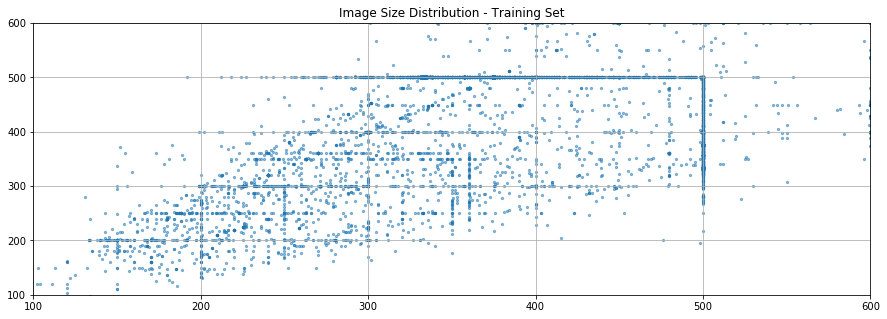

Height * Width (Average): 385.01 * 441.76


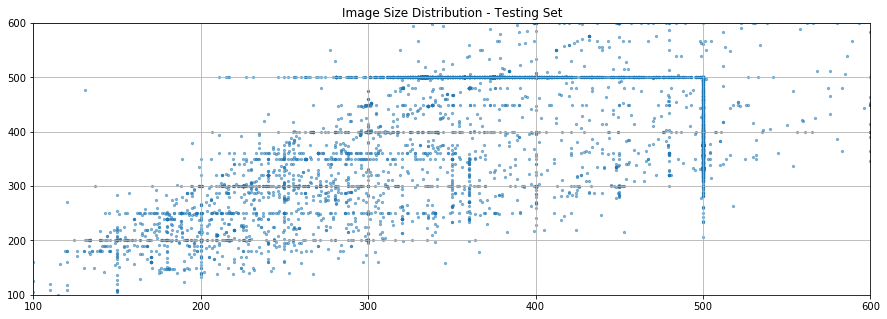

In [11]:
def size_distribution(imgs, title):
    height = []
    width = []
    for img in imgs:
        height.append(img.shape[0])
        width.append(img.shape[1])
    print("Height * Width (Average): %.2f * %.2f" % (np.average(height), np.average(width)))
    plt.figure(figsize=[15, 5])
    plt.scatter(height, width, s=5, alpha=0.5)
    plt.xlim([100, 600])
    plt.ylim([100, 600])
    plt.title(title)
    plt.grid(True)
    plt.show()
    
size_distribution(img_train, "Image Size Distribution - Training Set")
size_distribution(img_test, "Image Size Distribution - Testing Set")

## 查看数据集的平衡情况

- 该数据集还是比较不均衡的，不少类型的样本数量差距能够达到一倍。
- 每个狗品种类型的样本数量并不多，取值范围在60-120张左右。

In [53]:
breeds = list(set(Y_train['breed']))
breeds.sort()
breeds2idx = {breed : idx for idx, breed in enumerate(breeds)}
Y_train_idx = [breeds2idx[label] for label in Y_train['breed']]

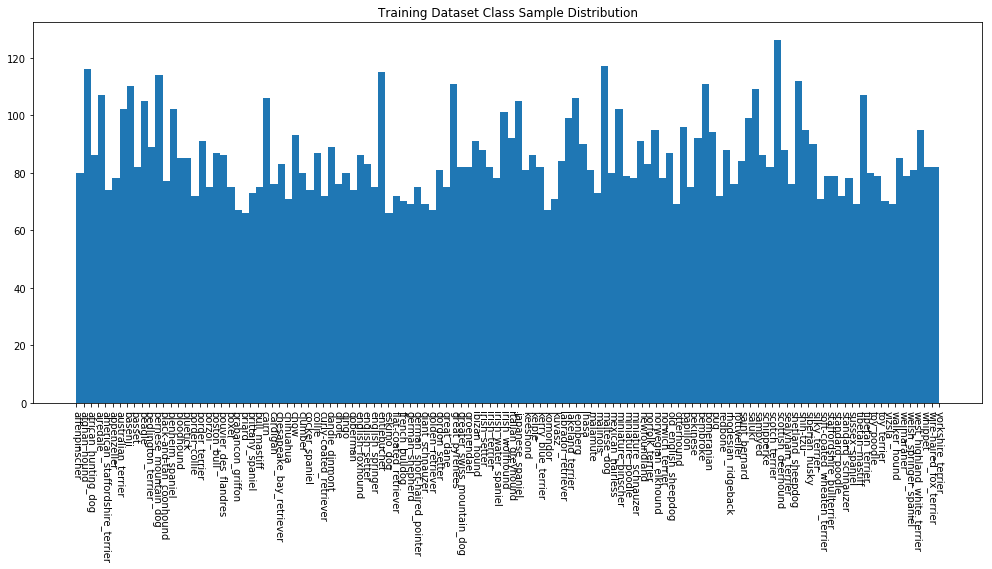

In [73]:
plt.figure(figsize=(17, 7))
plt.hist(Y_train_idx, bins=120)
plt.xticks(range(120), breeds, rotation=-90)
plt.title("Training Dataset Class Sample Distribution")
plt.show()

针对非平衡数据集的一些思路

    - 按照出现比例进行过采样和欠采样，使采样后的数据集类型达到平衡。
    
    - 使用数据增强对样本较少的分类进行扩充。